# CMS Open Payments analysis

<p><a name="sections"></a></p>


## Sections

- <a href="#import">Import data and Python packages</a><br>
- <a href="#cleaning">Assess Data Quality & Missing Values</a><br>
- <a href="#exploratory">Exploratory Data Analysis</a><br>
- <a href="#prediction">Prediction and Results</a><br>

<p><a name="import"></a></p>

## <i>1. Import data and Python packages</i>

In [125]:
#Import all the necessary packages for data analysis 

import pandas as pd
import numpy as np

import sklearn
from sklearn import model_selection, linear_model
from sklearn import feature_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
import re


from sklearn.tree import DecisionTreeRegressor


from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


#from sklearn import svm, datasets
#from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

In [2]:
#Import datasets

general = pd.read_csv('data/OP_DTL_GNRL_PGYR2017_P06282019.csv',low_memory=False)
#general = pd.read_csv('data/OP_DTL_GNRL_Sample.csv',low_memory=False)

research = pd.read_csv('data/OP_DTL_RSRCH_PGYR2017_P06282019.csv',low_memory=False)
ownership = pd.read_csv('data/OP_DTL_OWNRSHP_PGYR2017_P06282019.csv',low_memory=False)
removed = pd.read_csv('data/OP_REMOVED_DELETED_PGYR2017_P06282019.csv',low_memory=False)

In [6]:
#Flag research records

general['Research']=0.0
research['Research']=1.0
ownership['Research']=0.0
removed['Research']=0.0

In [7]:
print(general.shape)
print(research.shape)
print(ownership.shape)
print(removed.shape)

(11239733, 76)
(653488, 177)
(2840, 30)
(95583, 5)


In [8]:
#Remove null records

general.dropna(how='all', inplace=True)
research.dropna(how='all', inplace=True)
ownership.dropna(how='all', inplace=True)
removed.dropna(how='all', inplace=True)

In [18]:
general.info()
research.info()
ownership.info()
removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11239733 entries, 0 to 11239732
Data columns (total 76 columns):
Change_Type                                                          object
Covered_Recipient_Type                                               object
Teaching_Hospital_CCN                                                float64
Teaching_Hospital_ID                                                 float64
Teaching_Hospital_Name                                               object
Physician_Profile_ID                                                 float64
Physician_First_Name                                                 object
Physician_Middle_Name                                                object
Physician_Last_Name                                                  object
Physician_Name_Suffix                                                object
Recipient_Primary_Business_Street_Address_Line1                      object
Recipient_Primary_Business_Street_Address_Line

In [19]:
#Remove Ownership and Removed datasets (statistically insignificant)
#Reduce the number of attributes (columns) 

general_data=general[['Record_ID','Teaching_Hospital_Name','Physician_First_Name','Physician_Last_Name','Physician_Primary_Type','Recipient_State','Recipient_Zip_Code','Recipient_Country','Physician_Primary_Type','Physician_Specialty','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name','Total_Amount_of_Payment_USDollars','Covered_Recipient_Type','Research']]
research_data=research[['Record_ID','Teaching_Hospital_Name','Physician_First_Name','Physician_Last_Name','Physician_Primary_Type','Recipient_State','Recipient_Zip_Code','Recipient_Country','Physician_Primary_Type','Physician_Specialty','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name','Total_Amount_of_Payment_USDollars','Covered_Recipient_Type','Research']]

In [35]:
print(general_data.shape)
print(research_data.shape)

(11239733, 14)
(653488, 14)


In [36]:
general_data.head()

,Record_ID,Teaching_Hospital_Name,Physician_First_Name,Physician_Last_Name,Physician_Primary_Type,Recipient_State,Recipient_Zip_Code,Recipient_Country,Physician_Primary_Type,Physician_Specialty,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Total_Amount_of_Payment_USDollars,Covered_Recipient_Type,Research
0,422181493,NaN,MARK,GINSBURG,Doctor of Osteopathy,PA,19013,United States,Doctor of Osteopathy,Allopathic & Osteopathic Physicians|Otolaryngo...,Bovie Medical Corporation,22.43,Covered Recipient Physician,0.0
1,422707591,NaN,DIANE,BARRETT,Medical Doctor,VA,20166,United States,Medical Doctor,Allopathic & Osteopathic Physicians|General Pr...,Mission Pharmacal Company,22.17,Covered Recipient Physician,0.0
2,423062429,NaN,BONNIE,BARSKY,Medical Doctor,IL,60035,United States,Medical Doctor,Allopathic & Osteopathic Physicians|General Pr...,Mission Pharmacal Company,23.53,Covered Recipient Physician,0.0
3,423062439,NaN,JANINE,BARSOUM,Doctor of Osteopathy,PA,19355,United States,Doctor of Osteopathy,Allopathic & Osteopathic Physicians|General Pr...,Mission Pharmacal Company,17.82,Covered Recipient Physician,0.0
4,422181495,NaN,ARNOLD,ALMONTE,Doctor of Osteopathy,CA,95762,United States,Doctor of Osteopathy,Allopathic & Osteopathic Physicians|Surgery|Pl...,Bovie Medical Corporation,3.88,Covered Recipient Physician,0.0


In [37]:
research_data.head()

,Record_ID,Teaching_Hospital_Name,Physician_First_Name,Physician_Last_Name,Physician_Primary_Type,Recipient_State,Recipient_Zip_Code,Recipient_Country,Physician_Primary_Type,Physician_Specialty,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Total_Amount_of_Payment_USDollars,Covered_Recipient_Type,Research
0,493381041,GRADY MEMORIAL HOSPITAL,NaN,NaN,NaN,GA,30303,United States,NaN,NaN,"Pharmacyclics LLC, An AbbVie Company",50.0,Covered Recipient Teaching Hospital,1.0
1,455805444,ST. FRANCIS HOSPITAL,NaN,NaN,NaN,WI,53215,United States,NaN,NaN,"Biogen, Inc.",5.0,Covered Recipient Teaching Hospital,1.0
2,501931627,NaN,BERNARD,STULBERG,Medical Doctor,OH,44139-2839,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Orthopaedi...,Corin USA,800.0,Covered Recipient Physician,1.0
3,501847091,U OF U HOSPITALS & CLINICS,NaN,NaN,NaN,UT,84132,United States,NaN,NaN,Pfizer Inc.,600.0,Covered Recipient Teaching Hospital,1.0
4,446594329,DANBURY HOSPITAL,NaN,NaN,NaN,CT,06810-6099,United States,NaN,NaN,Boston Scientific Corporation,2652.0,Covered Recipient Teaching Hospital,1.0


In [38]:
#Join datasets

total=[general_data,research_data]
cms_data=pd.concat(total)
print(cms_data.shape)

(11893221, 14)


<p><a name="cleaning"></a></p>

## <i>2. Assess Data Quality & Missing Values</i>

In [39]:
#Determine the cleaness of the dataset and missing values 

cms_data.isnull().sum()

Record_ID                                                               0
Teaching_Hospital_Name                                           11746376
Physician_First_Name                                               667289
Physician_Last_Name                                                667457
Physician_Primary_Type                                             667161
Recipient_State                                                      1570
Recipient_Zip_Code                                                   1570
Recipient_Country                                                     659
Physician_Primary_Type                                             667161
Physician_Specialty                                                681054
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name           0
Total_Amount_of_Payment_USDollars                                       0
Covered_Recipient_Type                                                  0
Research                              

In [40]:
#Clean null values on key categorical attributes

cms_data['Physician_Primary_Type'] = cms_data['Physician_Primary_Type'].fillna('Not a Physician')
print(cms_data.shape)
cms_data.isnull().sum()

(11893221, 14)


Record_ID                                                               0
Teaching_Hospital_Name                                           11746376
Physician_First_Name                                               667289
Physician_Last_Name                                                667457
Physician_Primary_Type                                                  0
Recipient_State                                                      1570
Recipient_Zip_Code                                                   1570
Recipient_Country                                                     659
Physician_Primary_Type                                                  0
Physician_Specialty                                                681054
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name           0
Total_Amount_of_Payment_USDollars                                       0
Covered_Recipient_Type                                                  0
Research                              

<p><a name="exploratory"></a></p>

## <i>3. Exploratory Data Analysis</i>

#### 3.1. Sampling and Feature Analysis

In [41]:
#Sample size=883,282 (95% Confidence)

cms_data=cms_data.sample(883282)
print(cms_data.shape)
cms_data.sample(25)

(883282, 14)


,Record_ID,Teaching_Hospital_Name,Physician_First_Name,Physician_Last_Name,Physician_Primary_Type,Recipient_State,Recipient_Zip_Code,Recipient_Country,Physician_Primary_Type,Physician_Specialty,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Total_Amount_of_Payment_USDollars,Covered_Recipient_Type,Research
3795497,480432169,NaN,MITCHELL,RUBINOFF,Medical Doctor,NJ,07450,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,Gilead Sciences Inc,15.28,Covered Recipient Physician,0.0
1551185,495147897,NaN,SHARAD,BHATT,Medical Doctor,OH,44720-3625,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Psychiatry...,ACADIA Pharmaceuticals Inc,13.77,Covered Recipient Physician,0.0
10416370,479530501,NaN,JAVIER,ROCA,Medical Doctor,NY,11366,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,"GlaxoSmithKline, LLC.",16.92,Covered Recipient Physician,0.0
5198543,479068429,NaN,MARK,HIGGINS,Medical Doctor,CA,94114,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,ViiV Healthcare Company,21.84,Covered Recipient Physician,0.0
7797335,452865989,NaN,FRANCISCO,BARRERA,Medical Doctor,TX,78229,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Family Med...,Abbott Laboratories,23.02,Covered Recipient Physician,0.0
4505346,468758899,NaN,MARTA,MOLINA,Medical Doctor,TX,77546,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Family Med...,Novo Nordisk Inc,12.21,Covered Recipient Physician,0.0
210201,453648459,NaN,MARK,BLECHER,Medical Doctor,PA,19148-1536,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Ophthalmology,"Johnson & Johnson Surgical Vision, Inc.",51.98,Covered Recipient Physician,0.0
7083292,505607781,NaN,BRICE,BECKSTROM,Doctor of Dentistry,UT,84765,United States,Doctor of Dentistry,Dental Providers|Dentist|Orthodontics and Dent...,Ormco Corporation,0.57,Covered Recipient Physician,0.0
814645,479232719,NaN,ROBERT,FELDMAN,Medical Doctor,NY,13066,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Family Med...,"GlaxoSmithKline, LLC.",9.82,Covered Recipient Physician,0.0
6541274,499316973,NaN,LAWRENCE,EICHENFIELD,Medical Doctor,CA,92123-2778,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Dermatolog...,LEO Pharma AS,118.44,Covered Recipient Physician,0.0


#### 3.2. Exploration of Location

In [42]:
print(cms_data.shape)
cms_data['Recipient_Country'].value_counts()

(883282, 14)


United States                           883158
Great Britain (Uk)                          32
United States Minor Outlying Islands        11
Canada                                       9
Mexico                                       3
Germany                                      3
United Arab Emirates                         2
Japan                                        2
Thailand                                     2
India                                        1
Australia                                    1
Italy                                        1
Greece                                       1
Pakistan                                     1
Name: Recipient_Country, dtype: int64

In [43]:
cms_data=cms_data[pd.notnull(cms_data['Recipient_State'])]
print(cms_data.shape)
cms_data.isnull().sum()

(883158, 14)


Record_ID                                                             0
Teaching_Hospital_Name                                           872074
Physician_First_Name                                              49727
Physician_Last_Name                                               49739
Physician_Primary_Type                                                0
Recipient_State                                                       0
Recipient_Zip_Code                                                    0
Recipient_Country                                                     0
Physician_Primary_Type                                                0
Physician_Specialty                                               50703
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name         0
Total_Amount_of_Payment_USDollars                                     0
Covered_Recipient_Type                                                0
Research                                                        

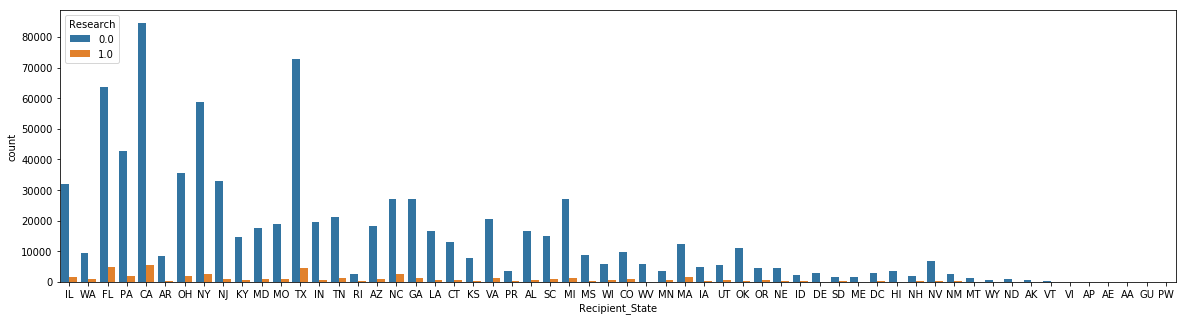

In [81]:
fig = plt.gcf()
fig.set_size_inches(20, 5)
sns.countplot(x='Recipient_State',hue='Research',data=cms_data)

#### 3.3. Exploration of Type of Payments

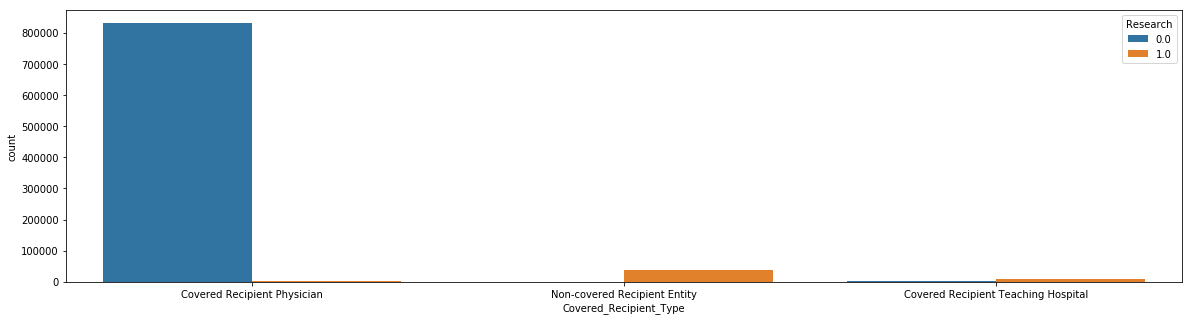

In [45]:
fig = plt.gcf()
fig.set_size_inches(20, 5)
sns.countplot(x='Covered_Recipient_Type',hue='Research',data=cms_data)

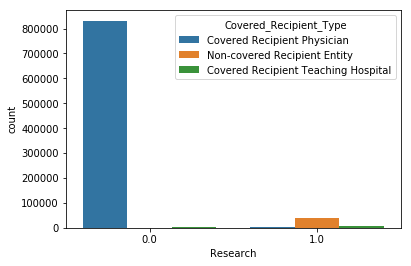

In [48]:
sns.countplot(x='Research',hue='Covered_Recipient_Type',data=cms_data)

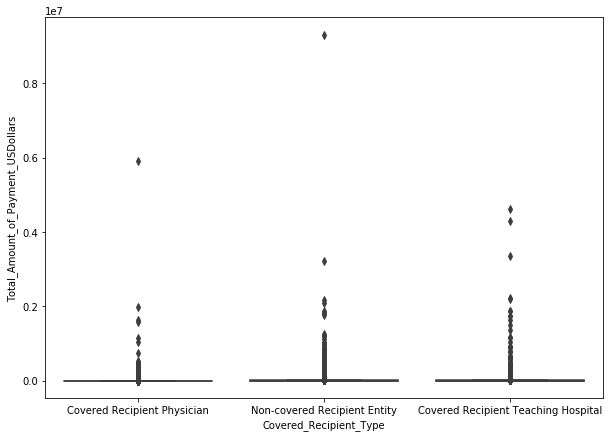

In [124]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Covered_Recipient_Type',y='Total_Amount_of_Payment_USDollars',data=cms_data)

#### 3.4. Feature Engineering

In [107]:
#Create categorical dummy variables

#physicianType_dummy = pd.get_dummies(cms_data['Physician_Primary_Type'])
#state_dummy = pd.get_dummies(cms_data['Recipient_State'])
paymentType_dummy = pd.get_dummies(cms_data['Covered_Recipient_Type'])

<p><a name="prediction"></a></p>

## <i>4. Prediction and Results</i>

#### 4.1. Logistic Regression

In [112]:
y = np.array(cms_data['Research'])
y.shape

(883158,)

In [113]:
X = np.array(cms_data[['Total_Amount_of_Payment_USDollars']])

In [114]:
X.shape

(883158, 1)

In [115]:
np.hstack([X, paymentType_dummy]).shape

(883158, 4)

In [141]:
#Cross validation to split the data 70% training and %30 testing

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [142]:
#Fit model to the training set

model = LogisticRegression()
model.fit(X_train,y_train)
model.score(X_train, y_train)

C:\Users\s_mas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9477863509163553

In [143]:
#Perform prediction

prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    250384
         1.0       0.87      0.07      0.12     14564

   micro avg       0.95      0.95      0.95    264948
   macro avg       0.91      0.53      0.55    264948
weighted avg       0.94      0.95      0.93    264948



In [147]:
# check classification scores of logistic regression

prediction_proba = model.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, prediction_proba)
print('Train/Test split results:')
print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, prediction))
print(model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, prediction_proba))
print(model.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.948
LogisticRegression log_loss is 0.194
LogisticRegression auc is 0.900


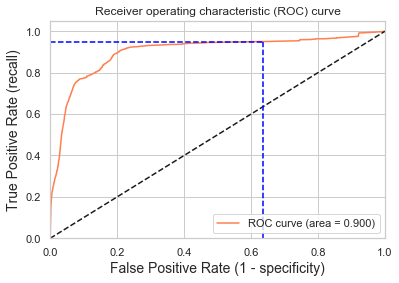

Using a threshold of 0.049 guarantees a sensitivity of 0.950 and a specificity of 0.363, i.e. a false positive rate of 63.68%.


In [150]:
idx = np.min(np.where(tpr > 0.95)) # index threshold 

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [148]:
RMSE=math.sqrt(mean_squared_error(y_true=y_test,y_pred=prediction))

In [149]:
print(RMSE)

0.22765991775207695


#### Visualization of the Models using Receiver Characteristic Curve (ROC) for Logistic Regression

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.900


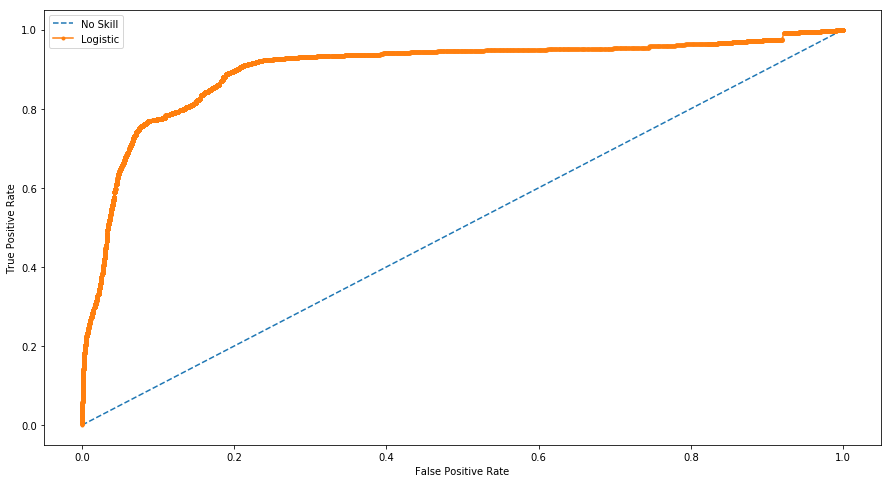

In [72]:
# roc curve and auc - generate a no skill prediction (majority class)

ns_probs = [0 for _ in range(len(y_test))]

# fit a model

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()


fig = plt.gcf()
fig.set_size_inches(15, 8)

# show the plot
plt.show()

#### 4.2. Decision Tree

In [63]:
#Decision tree approach (top down)

regressor = DecisionTreeRegressor(max_depth=20)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [64]:
prediction = regressor.predict(X_test)
prediction

array([0.08255659, 0.        , 0.99619772, ..., 0.0755814 , 0.01692866,
       0.02083333])

In [65]:
print('Accuracy of Random forest on test set: {:.3f}'.format(regressor.score(X_test, y_test)))

Accuracy of Random forest on test set: 0.384


In [41]:
RMSE=math.sqrt(mean_squared_error(y_true = y_test, y_pred = prediction))
print(RMSE)

0.218395590040479


In [66]:
RMSE=math.sqrt(mean_squared_error(y_true = y_test, y_pred = prediction))
print(RMSE)

0.17886039405199913


#### 4.3. Random Forest

In [67]:
#from sklearn.datasets import make_classification

rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [68]:
prediction = rfc.predict(X_test)
print('Accuracy of Random forest on test set: {:.3f}'.format(rfc.score(X_test, y_test)))

Accuracy of Random forest on test set: 0.952


In [69]:
RMSE=math.sqrt(mean_squared_error(y_true = y_test, y_pred = prediction))
print(RMSE)

0.21859314075431616
